### Libraries

In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor

### Read from google drive

In [3]:
# url = "https://drive.google.com/file/d/16aOg3J57O1Gmx_7LSIMt-hPmMxYXtDH-/view?usp=sharing"

url = "https://drive.google.com/file/d/1YVppwFGtto12XLqDWos4xP-g2aXSqg8g/view?usp=sharing" #url: extracted_coords_jakarta_traffic
gdrive_df = pd.read_csv('https://drive.usercontent.google.com/download?id={}&export=download&authuser=0&confirm=t'.format(url.split('/')[-2]), index_col=[0])
gdrive_df.head()

KeyboardInterrupt: 

## Exploratory Data Analysis

In [4]:
# df_eda = gdrive_df.copy()
df_eda = pd.read_csv("../Data-Mining-Jakarta-Traffic (local)/extracted_coords_jakarta_traffic.csv", index_col=[0])

def change_day_to_num(x):
    dayDict = {
        'MONDAY': 0,
        'TUESDAY': 1, 
        'WEDNESDAY': 2,
        'THURSDAY': 3,
        'FRIDAY': 4,
        'SATURDAY': 5,
        'SUNDAY':6
    }

    return dayDict[x]

def change_num_to_day(x):
    dayDict = {
        0: 'MONDAY', 
        1: 'TUESDAY', 
        2: 'WEDNESDAY', 
        3: 'THURSDAY', 
        4: 'FRIDAY', 
        5: 'SATURDAY', 
        6: 'SUNDAY'
    }

    return dayDict[x]

df_eda['dayCode'] = df_eda['day'].apply(lambda x: change_day_to_num(x))

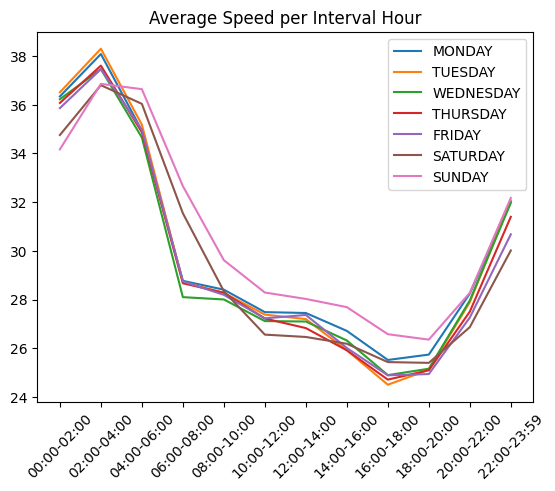

In [5]:
for i in range(7):
    day_name = change_num_to_day(i)
    daySeries = df_eda[df_eda['dayCode'] == i].copy()

    hour_interval_list_day = sorted(daySeries['hour_interval'].unique())
    avg_speed_per_interval_hour_day = daySeries.groupby(['hour_interval'], sort=True)['averageSpeed'].mean()
    
    plt.plot(hour_interval_list_day, avg_speed_per_interval_hour_day, label=day_name)
    plt.xticks(rotation=45)
    plt.legend()
    plt.title(f"Average Speed per Interval Hour")

plt.show()

1. Secara keseluruhan, setiap jalan di Jakarta memang sering mengalami kemacetan untuk tiap jamnya. Hal ini dapat dilihat dari interval tengah malam (0:00 - 2:00) yang rata-rata kecepatannya di bawah 40 .../...

2. Dari semua interval jam, kecepatan terendah berada pada kisaran jam 16.00-18.00 pada hari Selasa

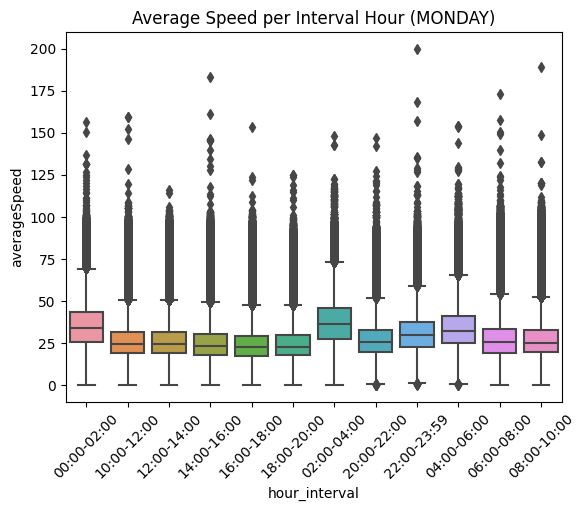

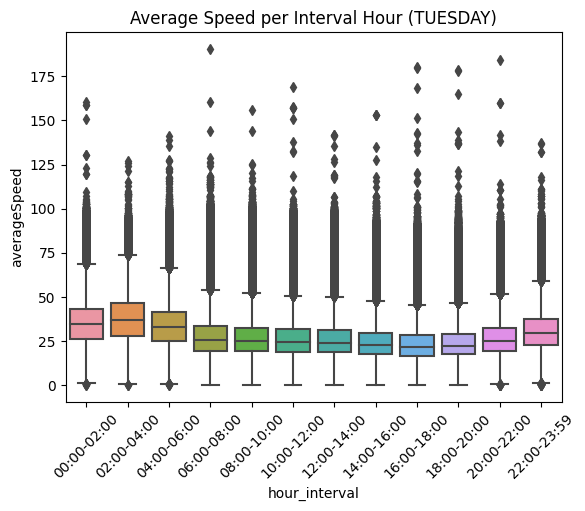

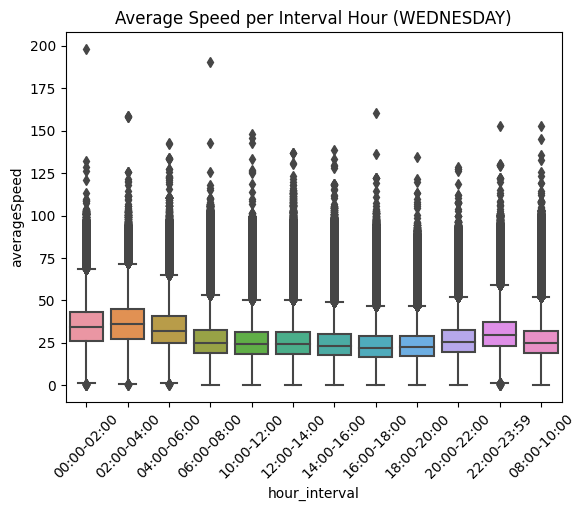

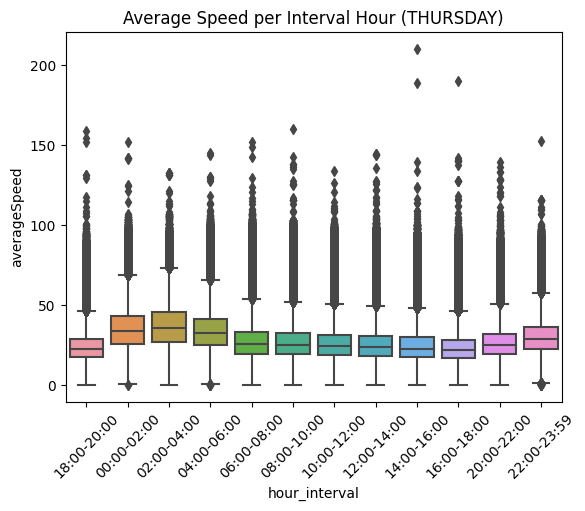

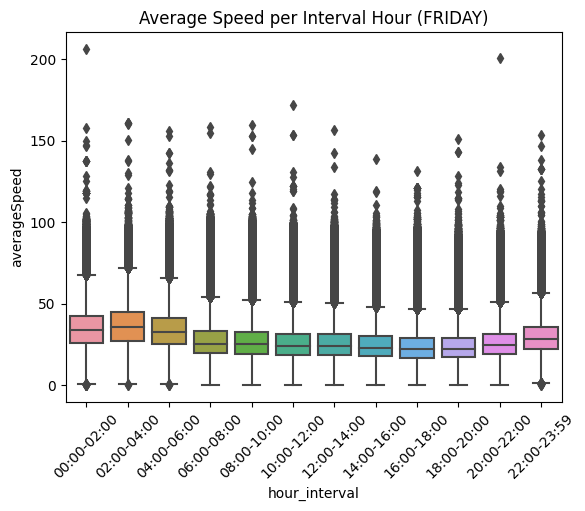

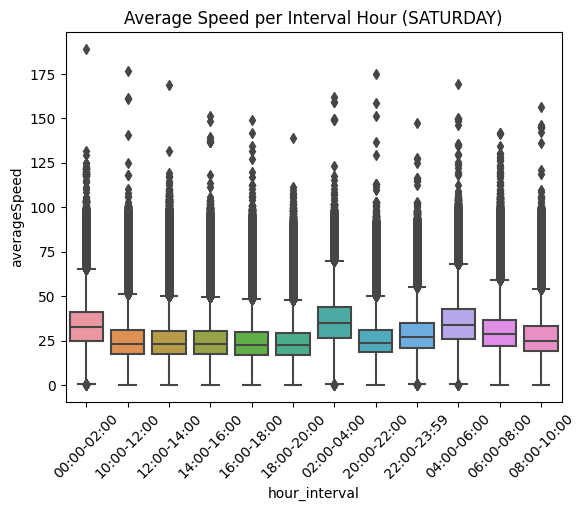

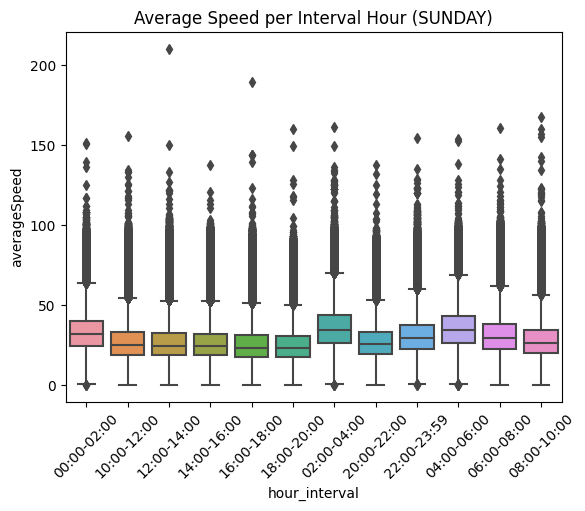

In [6]:
for i in range(7):
    day_name = change_num_to_day(i)
    daySeries = df_eda[df_eda['dayCode'] == i].copy()

    hour_interval_list_day = sorted(daySeries['hour_interval'].unique())
    avg_speed_per_interval_hour_day = daySeries.groupby(['hour_interval'], sort=True)['averageSpeed']

    sns.boxplot(data=daySeries, x='hour_interval', y='averageSpeed')
    
    plt.xticks(rotation=45)
    plt.title(f"Average Speed per Interval Hour ({day_name})")

    plt.show()

Pada pencilan, dapat terlihat bahwa terdapat jalan tertentu di mana dapat menghasilkan kecepatan kendaraan yang sangat tinggi. Hal ini berarti bahwa ada kemungkinan besar terdapat jalan-jalan tertentu di waktu tertentu yang tidak sering mengalami kemacetan.

In [42]:
# calculate travel time index
def calculate_tti(avgTravelTime, distance, speedLimit):
    # average travel time free-flow congestion
    avgTravelTimeFC = distance/speedLimit

    return avgTravelTime/avgTravelTimeFC

df_eda['travelTimeIndex'] = df_eda['averageTravelTime'] / (df_eda['distance'] / (df_eda['speedLimit'] * 1000 / 3600))

In [43]:
df_eda['travelTimeIndex'].describe()

count    1.139654e+07
mean     2.626847e+00
std      2.610304e+00
min      9.456265e-02
25%      1.569177e+00
50%      2.158768e+00
75%      3.012383e+00
max      8.000000e+02
Name: travelTimeIndex, dtype: float64

In [44]:
no_congestion_df = df_eda[df_eda['travelTimeIndex'] <= 1.2]
with_congestion_df = df_eda[df_eda['travelTimeIndex'] > 1.2]

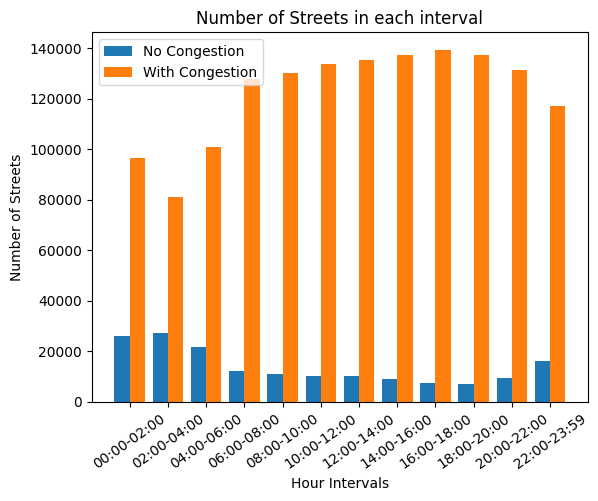

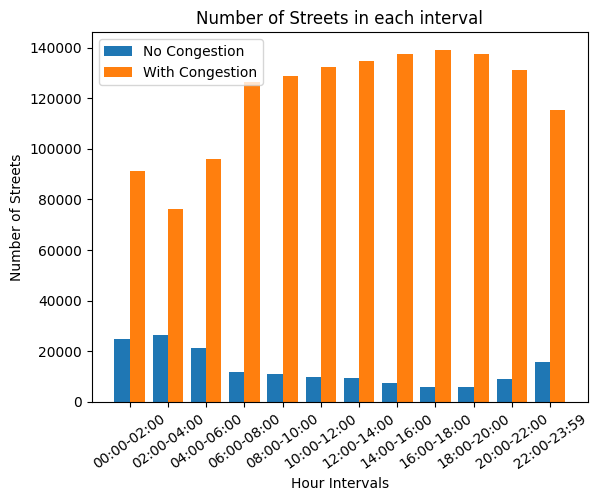

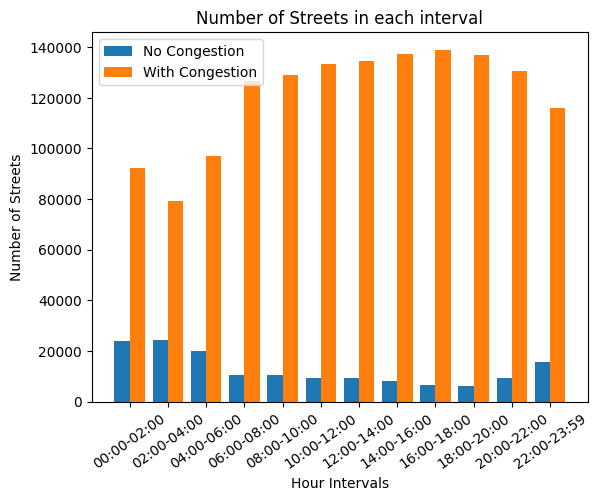

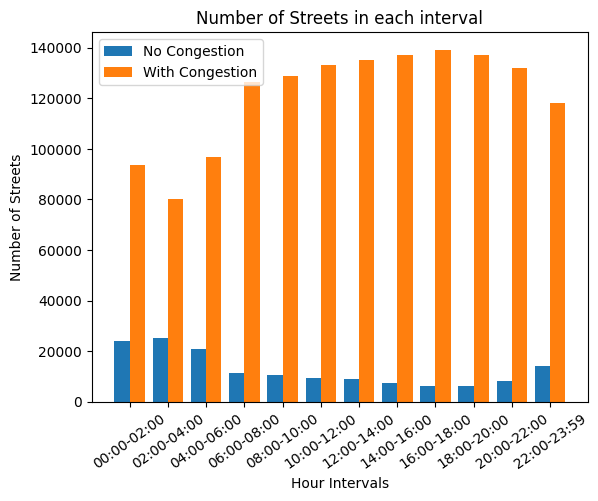

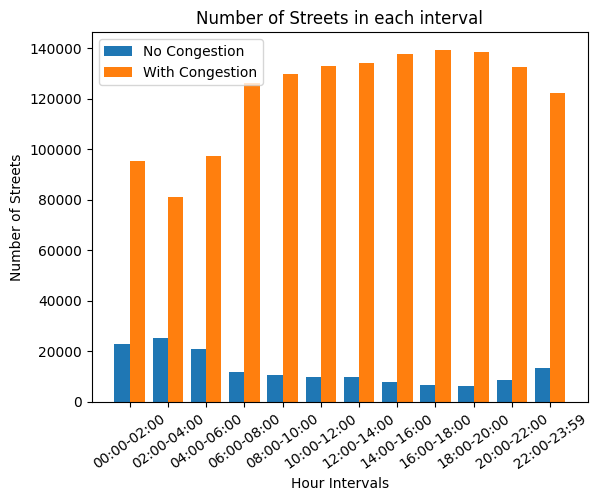

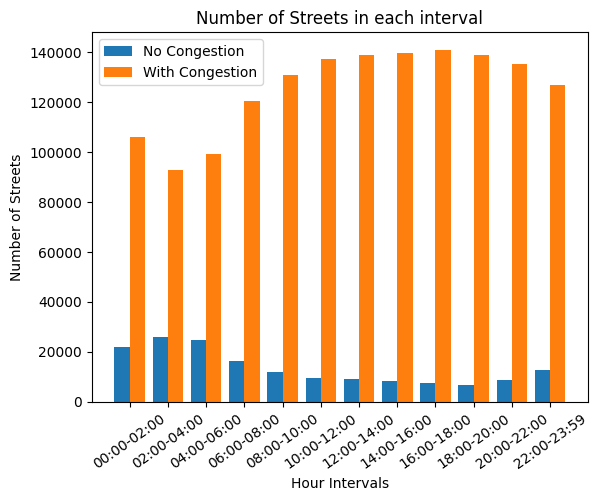

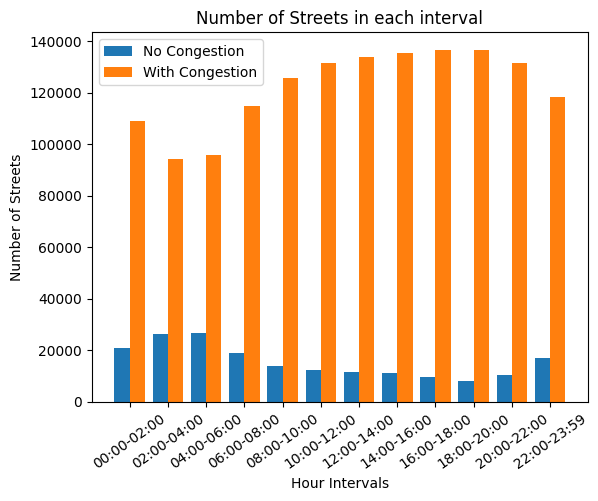

In [45]:
import numpy as np

for i in range(7):
    nc_daySeries = no_congestion_df[no_congestion_df['dayCode'] == i]
    wc_daySeries = with_congestion_df[with_congestion_df['dayCode'] == i]

    hour_interval_list = sorted(nc_daySeries['hour_interval'].unique())

    nc_list = []
    wc_list = []

    X_axis = np.arange(len(hour_interval_list))
    for j in hour_interval_list:
        nc_count = len(nc_daySeries[nc_daySeries['hour_interval'] == j])
        wc_count = len(wc_daySeries[wc_daySeries['hour_interval'] == j])

        nc_list.append(nc_count)
        wc_list.append(wc_count)
    
    plt.bar(X_axis - 0.2, nc_list, 0.4, label = 'No Congestion') 
    plt.bar(X_axis + 0.2, wc_list, 0.4, label = 'With Congestion') 
    
    plt.xticks(X_axis, hour_interval_list, rotation=35) 
    plt.xlabel("Hour Intervals") 
    plt.ylabel("Number of Streets") 
    plt.title("Number of Streets in each interval") 
    plt.legend() 
    plt.show() 

In [46]:
df_eda_monday_10_12 = df_eda[(df_eda['day'] == 'MONDAY') & (df_eda['hour_interval'] == '10:00-12:00')]

In [48]:
import folium

# Sample data
map_jakarta = folium.Map(location=[-6.2, 106.85], zoom_start=12)

# Function to add lines to the map
def add_lines_to_map(df_eda_monday_10_12, map_object):
    for _, row in df_eda_monday_10_12.iterrows():
        if row['travelTimeIndex'] < 1.3:
            color = 'green' 
        elif row['travelTimeIndex'] < 2:
            color = 'orange'
        else: 
            color = 'red'
        folium.PolyLine(
            locations=[(row['lat1'], row['lon1']), (row['lat2'], row['lon2'])],
            color=color,
            weight=5
        ).add_to(map_object)

# Add lines to the map
add_lines_to_map(df_eda_monday_10_12, map_jakarta)

# Save the map to an HTML file
map_jakarta.save('../roads/jakarta_traffic_oct_monday_10-12.html')


### Data Preprocessing

In [2]:
df = pd.read_csv("../Data-Mining-Jakarta-Traffic (local)/extracted_coords_jakarta_traffic.csv", index_col=[0])
df.head()

,day,hour_interval,segmentId,speedLimit,frc,streetName,distance,harmonicAverageSpeed,medianSpeed,averageSpeed,standardDeviationSpeed,travelTimeStandardDeviation,sampleSize,averageTravelTime,medianTravelTime,travelTimeRatio,lat1,lon1,lat2,lon2
0,MONDAY,00:00-02:00,-13600003425517,18,2,Jalan Trans Yogie,16.33,31.52,24.8,57.60,59.87,1.23,3,1.86,2.37,1.0,-6.37570,106.90701,-6.37555,106.90698
1,MONDAY,00:00-02:00,-13600001618936,50,5,Jalan Karya Bakti,34.33,28.10,28.1,28.10,0.00,0.00,1,4.40,4.40,1.0,-6.36841,106.89396,-6.36829,106.89368
2,MONDAY,00:00-02:00,-13600002440919,50,5,Jalan Karya Bakti,10.44,27.50,27.5,27.50,0.00,0.00,1,1.37,1.37,1.0,-6.36829,106.89368,-6.36825,106.89359
3,MONDAY,00:00-02:00,-13600001175418,50,5,Jalan Karya Bakti,284.25,27.60,27.6,27.60,0.00,0.00,1,37.08,37.08,1.0,-6.36825,106.89359,-6.36731,106.89120
4,MONDAY,00:00-02:00,-13600001957379,50,5,Jalan Karya Bakti,93.00,33.53,31.9,35.23,10.02,2.57,3,9.99,10.50,1.0,-6.36731,106.89120,-6.36700,106.89042


In [32]:
df.shape

(11396536, 20)

In [33]:
df_sampled = df[(df.frc != 4) & (df.frc != 6)].reset_index(drop=True)

#### Calculating Midpoint

In [34]:
df_sampled['mid_lat'] = (df_sampled['lat1'] + df_sampled['lat2']) / 2
df_sampled['mid_lon'] = (df_sampled['lon1'] + df_sampled['lon2']) / 2

#### Calculated Midpoints for Geographical Binning

In [35]:
grid_size = 0.1

# Apply grid-based binning using midpoints
df_sampled['lat_bin'] = np.floor(df_sampled['mid_lat'] / grid_size) * grid_size
df_sampled['lon_bin'] = np.floor(df_sampled['mid_lon'] / grid_size) * grid_size

#### Geographical Clustering

In [36]:
kmeans = KMeans(n_clusters=5, random_state=42)
df_sampled['cluster'] = kmeans.fit_predict(df_sampled[['lat_bin', 'lon_bin']])

In [37]:
df_sampled['cluster'].value_counts()

1    2284187
0    1563800
3    1422078
2    1015763
4     414439
Name: cluster, dtype: int64

In [38]:
encoder = OneHotEncoder(sparse_output=False)
encoded_time_features = encoder.fit_transform(df_sampled[['day', 'hour_interval']])

In [39]:
encoded_time_df = pd.DataFrame(encoded_time_features, columns=encoder.get_feature_names_out(['day', 'hour_interval'])).reset_index(drop=True)

df_encoded = pd.concat([df_sampled.drop(['day', 'hour_interval'], axis=1), encoded_time_df], axis=1)
df_encoded.head()

,segmentId,speedLimit,frc,streetName,distance,harmonicAverageSpeed,medianSpeed,averageSpeed,standardDeviationSpeed,travelTimeStandardDeviation,...,hour_interval_04:00-06:00,hour_interval_06:00-08:00,hour_interval_08:00-10:00,hour_interval_10:00-12:00,hour_interval_12:00-14:00,hour_interval_14:00-16:00,hour_interval_16:00-18:00,hour_interval_18:00-20:00,hour_interval_20:00-22:00,hour_interval_22:00-23:59
0,-13600003425517,18,2,Jalan Trans Yogie,16.33,31.52,24.8,57.60,59.87,1.23,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-13600001618936,50,5,Jalan Karya Bakti,34.33,28.10,28.1,28.10,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-13600002440919,50,5,Jalan Karya Bakti,10.44,27.50,27.5,27.50,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-13600001175418,50,5,Jalan Karya Bakti,284.25,27.60,27.6,27.60,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-13600001957379,50,5,Jalan Karya Bakti,93.00,33.53,31.9,35.23,10.02,2.57,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Model

#### Linear Regression

In [40]:
features = df_encoded.drop(['streetName', 'segmentId', 'sampleSize', 'averageTravelTime', 'lat1', 'lon1',
       'lat2', 'lon2', 'mid_lat', 'mid_lon', 'lat_bin', 'lon_bin'], axis=1)  
target = df_encoded['averageTravelTime']

In [41]:
lr_model = LinearRegression()

In [42]:
lr_scores = cross_val_score(lr_model, features, target, cv=5, scoring='r2')  # 5-fold cross-validation

# Output the cross-validation lr_scores
print(f'Cross-Validation R2: {lr_scores}')
print(f'Average R2: {lr_scores.mean()}')

Cross-Validation R2: [0.9791961  0.97653573 0.97935408 0.98289035 0.98298548]
Average R2: 0.9801923503711556


In [43]:
lr_model.fit(features, target)
coefficients = lr_model.coef_
feature_importances = pd.DataFrame(coefficients, index=features.columns, columns=['importance'])

# Sort feature importances
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Display the feature importances
print(feature_importances)

                               importance
travelTimeRatio              2.148974e+06
medianTravelTime             8.316641e-01
travelTimeStandardDeviation  3.622374e-01
medianSpeed                  3.273735e-01
harmonicAverageSpeed         1.351512e-01
standardDeviationSpeed       1.106632e-01
cluster                      1.161788e-02
distance                     1.126187e-02
speedLimit                   3.927393e-03
frc                         -1.343303e-02
averageSpeed                -5.125003e-01
hour_interval_02:00-04:00   -6.659375e+06
hour_interval_00:00-02:00   -6.659376e+06
hour_interval_04:00-06:00   -6.659376e+06
hour_interval_16:00-18:00   -6.659376e+06
hour_interval_06:00-08:00   -6.659376e+06
hour_interval_14:00-16:00   -6.659376e+06
hour_interval_18:00-20:00   -6.659376e+06
hour_interval_08:00-10:00   -6.659376e+06
hour_interval_22:00-23:59   -6.659376e+06
hour_interval_10:00-12:00   -6.659376e+06
hour_interval_12:00-14:00   -6.659376e+06
hour_interval_20:00-22:00   -6.659

#### KNN

In [44]:
knn_model = KNeighborsRegressor()

knn_scores = cross_val_score(knn_model, features, target, cv=5, scoring='r2')

print(f'Cross-Validation R2: {knn_scores}')
print(f'Average R2: {knn_scores.mean()}')

#### MLP

In [ ]:
lgbm_model = LGBMRegressor()
lgbm_scores = cross_val_score(lgbm_model, features, target, cv=5, scoring='r2')

print(f'Cross-Validation R2: {lgbm_scores}')
print(f'Average R2: {lgbm_scores.mean()}')

NameError: name 'features' is not defined